In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline

/home/keanu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("train.tsv", sep="\t")

In [3]:
print(df.shape)
print(df.head())

(156060, 4)
   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  


In [4]:
for i in range(5):
    print( (df['Sentiment'] == 1).sum(),i)

27273 0
27273 1
27273 2
27273 3
27273 4


In [5]:
df['num_words'] = df['Phrase'].apply(lambda x : len(x.split()))

In [6]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,num_words
0,1,1,A series of escapades demonstrating the adage ...,1,37
1,2,1,A series of escapades demonstrating the adage ...,2,14
2,3,1,A series,2,2
3,4,1,A,2,1
4,5,1,series,2,1


In [7]:
bins = [0,50,75, np.inf]
df['bins'] = pd.cut(df.num_words, bins=[0,1,4,8,16, np.inf],
                     labels=['0-1', '1-4','4-8','8-16',
                            '>16'])

In [8]:
word_distribution = df.groupby('bins').size().reset_index().\
                               rename(columns={0:'counts'})

In [9]:
word_distribution.head()

,bins,counts
0,0-1,16531
1,1-4,61238
2,4-8,33491
3,8-16,27951
4,>16,16848


/home/keanu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Word distributions per bin')

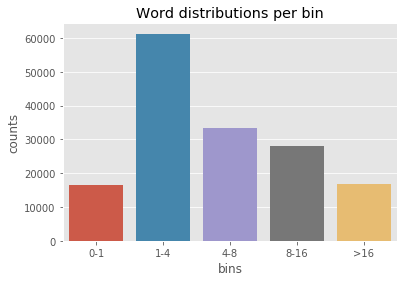

In [10]:
sns.barplot(x='bins',y='counts',\
            data=word_distribution).\
set_title("Word distributions per bin")

In [11]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,num_words,bins
0,1,1,A series of escapades demonstrating the adage ...,1,37,>16
1,2,1,A series of escapades demonstrating the adage ...,2,14,8-16
2,3,1,A series,2,2,1-4
3,4,1,A,2,1,0-1
4,5,1,series,2,1,0-1


In [12]:
num_class = len(np.unique(df.Sentiment.values))
y = df['Sentiment'].values

In [13]:
print(y.shape)

(156060,)


In [14]:
MAX_LENGTH = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Phrase'].values)
post_seq = tokenizer.texts_to_sequences(df['Phrase'].values)
post_seq_padded = pad_sequences(post_seq,maxlen=MAX_LENGTH)

In [15]:
X_train, X_test, y_train, y_test = train_test_split\
(post_seq_padded, y, test_size=0.05)

In [16]:
vocab_size = len(tokenizer.word_index) + 1

In [17]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          1956992   
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                409632    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,366,789
Trainable params: 2,366,789
Non-trainable params: 0
_________________________________________________________________
Train on 111192 samples, validate on 37065 samples
Epoch 1/5
111192/111192 [==============================] - 70s 630us/step - loss:

/home/keanu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


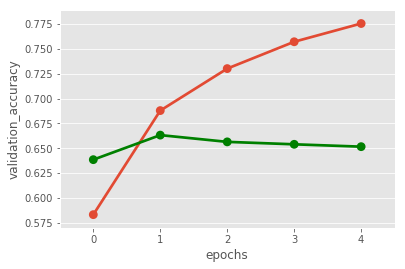

In [18]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [19]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6453927976419326

In [20]:
print(y_test.shape)

(7803,)


In [44]:
print(predicted[:5] )
print(X_test.shape)
print(X_train.shape)

[3 1 2 2 2]
(7803, 100)
(148257, 100)


In [21]:
df3 = pd.read_csv("test.tsv", sep="\t")

In [32]:
df3['num_words'] = df3['Phrase'].apply(lambda x : len(x.split()))

In [33]:
df3.head()

,PhraseId,SentenceId,Phrase,num_words
0,156061,8545,An intermittently pleasing but mostly routine ...,8
1,156062,8545,An intermittently pleasing but mostly routine ...,7
2,156063,8545,An,1
3,156064,8545,intermittently pleasing but mostly routine effort,6
4,156065,8545,intermittently pleasing but mostly routine,5


In [34]:
bins = [0,50,75, np.inf]
df3['bins'] = pd.cut(df3.num_words, bins=[0,1,4,8,16, np.inf],
                     labels=['0-1', '1-4','4-8','8-16',
                            '>16'])

In [37]:
word_distribution1 = df3.groupby('bins').size().reset_index().\
                               rename(columns={0:'counts'})

In [38]:
word_distribution1.head()

,bins,counts
0,0-1,10014
1,1-4,25482
2,4-8,13426
3,8-16,11045
4,>16,6324


/home/keanu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Word distributions per bin')

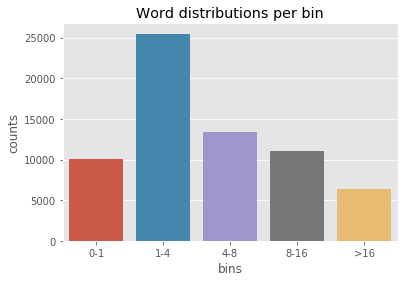

In [39]:
sns.barplot(x='bins',y='counts',\
            data=word_distribution1).\
set_title("Word distributions per bin")

In [40]:
df3.head()

,PhraseId,SentenceId,Phrase,num_words,bins
0,156061,8545,An intermittently pleasing but mostly routine ...,8,4-8
1,156062,8545,An intermittently pleasing but mostly routine ...,7,4-8
2,156063,8545,An,1,0-1
3,156064,8545,intermittently pleasing but mostly routine effort,6,4-8
4,156065,8545,intermittently pleasing but mostly routine,5,4-8


In [41]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(df3['Phrase'].values)
post_seq1 = tokenizer1.texts_to_sequences(df3['Phrase'].values)
post_seq_padded1 = pad_sequences(post_seq1,maxlen=MAX_LENGTH)

In [43]:
print(post_seq_padded1)

(66292, 100)


In [45]:
predicted1 = model.predict(post_seq_padded1)
predicted1 = np.argmax(predicted1, axis=1)

In [51]:
print(predicted1.shape)
print(predicted1[:5])

(66292,)
[1 1 2 1 1]


In [52]:
columns = "PhraseId,Sentiment"
df_sol = pd.DataFrame({'PhraseId':df3['PhraseId'], \
                       'Sentiment':predicted1})

In [54]:
print(df_sol[:5])

   PhraseId  Sentiment
0    156061          1
1    156062          1
2    156063          2
3    156064          1
4    156065          1


In [55]:
file = "submission.csv"
df_sol.to_csv(file,index=False)

In [59]:
#for i in range(5):
#    print( (df['Sentiment'] == 1).sum(),i)
print( (df_sol['Sentiment'] == 4).sum() )

1495
